# Neural Networks for jet images

Notebook for training and evaluating neural network taggers using jet images.

This example is about separating jets (collimated sprays of hadronic particles) using an "imaging" technique based on a convolutional neural network. SignaL jets are from hadronic decays of W bosons, while background jets are produced from the hadronisation of light quarks, or gluons. The jets are measured in the detector calorimeter, where they leave their energy. The images are the trnasverse energies deposited by a jet in the calorimeter cells, with each image being centred on the jet axis, and the weight of each cell is the transverse energy deposited. Jets from background tend to have most of the transverse enrgy deposited in the centre, while those from BG, that are actually composed of two very nearby jets, present rather a two-prong structure, and the network should be able to distinguish the two cases.
Write a convolutional neural network to distinguish the two classes, train it, and evaluate its performance.

### Import everything

In [ ]:
from __future__ import division, print_function
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch



import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from datetime import datetime
import os, sys
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.python.client import device_lib


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

np.random.seed(94) #for reproducibility

In [ ]:
#Some configuration for GPU machines, may not be necessary
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.8
session = tf.compat.v1.Session(config=config)

## Introduction

The file "20190920_pt600.0_1500.0_40bins_10k.npz" is a dataset of images of different jets taken by one of the detectors at the Large Hadron Collider (LHC). Jets are a stream of hadrons produced by a proton-proton collision at the LHC. [7].

The jets are of 3 types; a QCD jet (jets formed directly from partons), W jet (jets formed from W-decay) and Top-Quark Jets (jets formed from Top-decay). We can train a Convolutional Nueral Network (CNN) to identify which jet type it is when an image is inputted. 

A Top-jet is made of 3 smaller jets (which are shown as 3 bright spots on the images), W-jet is made of 2 smaller jets (which are shown as 2 bright spots on the images) and a QCD-jet is made of only 1 jet. In this notebook, we will be training a CNN to distinguish betweeen a W-jet (also known as the signal) and a QCD-jet (also known as background).

Since we are building a CNN to identify weather a jet is W or QCD, the problem presented is a binary classification problem. This is when the number of possible classifications of data is 2. 

## Splitting Data into Signal and Background Jets

We need to split "20190920_pt600.0_1500.0_40bins_10k.npz" into the Top, W and QCD jets. Each type has 10,000 images and each type has a title; 'top_jet_images', 'W_jet_images', 'QCD_jet_images'. So, we need to use `input_data['jet_type'][:10000]` to split each type. Once this is complete, we can asign the signal and background jets.

In [ ]:
input_data = np.load("20190920_pt600.0_1500.0_40bins_10k.npz") #load dataset
print("The Shape of the Full Input Dataset:", np.shape(input_data))


#Split dataset into the 3 jet types:
top_samples = input_data['top_jet_images'][:10000]
w_samples = input_data['W_jet_images'][:10000]
qcd_samples = input_data['QCD_jet_images'][:10000]

print() #space
print("Number of Top-Jet Images:", len(top_samples))
print("Number of W-Jet Images:", len(w_samples))
print("Number of QCD-Jet Images:", len(top_samples))


#Asign signal and backroung jets:
X_BG = qcd_samples
X_S = w_samples

print()
print("Number of Signal Images:", len(X_S))
print("Number of Background Images:", len(X_BG))

The Shape of the Full Input Dataset: (30,)

Number of Top-Jet Images: 10000
Number of W-Jet Images: 10000
Number of QCD-Jet Images: 10000

Number of Signal Images: 10000
Number of Background Images: 10000


## Obtaining Test and Training Data

We need training data that will train the CNN by setting the initial appropriate weights and biases. Only then will we be able to test the CNN propficiency with the testing data. First, we must combine the background and signal jet images into a single array. This array will be the input in to the CNN in order for it to identify either a BG or S jet. Thereafter, the CNN will be trained on the first 80% of the array. The latter 20% will be the test data. However, we also need to make the label data. This is an array of 0s and 1s. The 0s correspond to signal jets and 1s correspond to background jets. This is the nueral network will be output the probability of the image being a background jet (1-being highest probability and 0 being lowest). Thus, creating an array with 1s and 0s means that 1 will be a background jet and 0 will be a signal jet.

In [ ]:
np.random.seed(94) #for reproducibility

#randomly shuffle data:
np.random.shuffle(X_BG)
np.random.shuffle(X_S)


#Label data:
y_S = np.zeros(len(X_S)) 
y_BG = np.ones(len(X_BG)) 

#Stack signal and background data (both label and otherwise) on top of each other:
X = np.append(X_S, X_BG, axis=0)
y = np.append(y_S, y_BG, axis=0)


#column representation:
y = y.reshape(len(y), 1)
print("The shape of the total label data y is:",np.shape(y))

#Add a dimensiion onto the data array for colour since CNNs are built to take colour images:
X = X.reshape( (X.shape[0], X.shape[1], X.shape[2], 1))
#So, input shape is: 1 image channel (the first 3 dimensions of the array) + 1 colour channel


#Split data into training and testing samples:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True)


#Information about the images:
print("Shape of Input Data; W + QCD (no of images X pixel X pixel X colour channel)",np.shape(X))
print("Shape of 1 Image (pixel X pixel X colour channel):", X[0].shape)
print("Number of input samples:", len(X))

print()
print("Shape of Input Data (no of images X pixel X pixel X colour channel):", np.shape(X))

print()
print("Number of training images:", len(X_train))
print("Number of test images:", len(X_test))

The shape of the total label data y is: (20000, 1)
Shape of Input Data; W + QCD (no of images X pixel X pixel X colour channel) (20000, 40, 40, 1)
Shape of 1 Image (pixel X pixel X colour channel): (40, 40, 1)
Number of input samples: 20000

Shape of Input Data (no of images X pixel X pixel X colour channel): (20000, 40, 40, 1)

Number of training images: 16000
Number of test images: 4000


## Plotting Jet Images

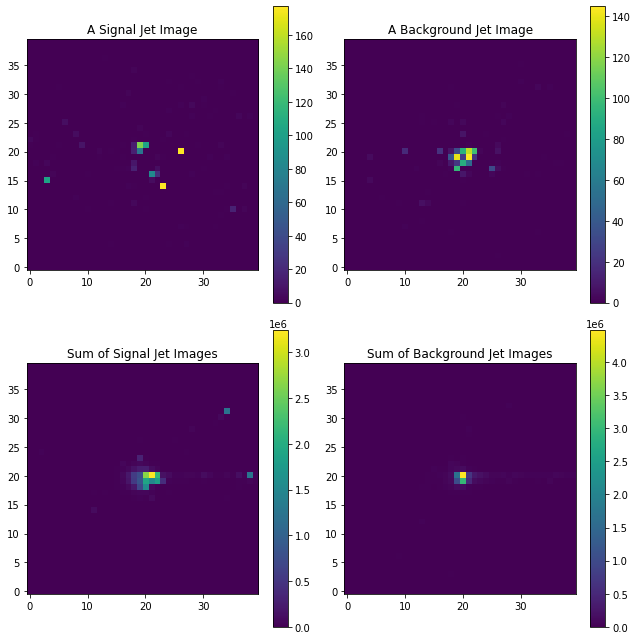

In [ ]:
np.random.seed(94) #for reproducibility

iimg_sig = np.random.randint(0,len(X_S))  #pick random signal image to plot
iimg_bkg = np.random.randint(0,len(X_BG)) #pick random background image to plot

fig, ax = plt.subplots(2,2, figsize=(9, 9))

ax[0][0].set_title("A Signal Jet Image")
im1 = ax[0][0].imshow(X_S[iimg_sig].reshape(X_S.shape[1], X_S.shape[2]), origin="lower")
fig.colorbar(im1, ax=ax[0,0])
fig.tight_layout()

ax[0][1].set_title("A Background Jet Image")
im2 = ax[0][1].imshow(X_BG[iimg_bkg].reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
fig.colorbar(im2, ax=ax[0,1])
fig.tight_layout()

ax[1][0].set_title("Sum of Signal Jet Images")
im3 = ax[1][0].imshow(np.sum(X_S, axis=0).reshape(X_S.shape[1], X_S.shape[2]), origin="lower")
fig.colorbar(im3, ax=ax[1,0])
fig.tight_layout()

ax[1][1].set_title("Sum of Background Jet Images")
im4 = ax[1][1].imshow(np.sum(X_BG, axis=0).reshape(X_BG.shape[1], X_BG.shape[2]), origin="lower")
fig.colorbar(im4, ax=ax[1,1])
fig.tight_layout()

As mentioned in the introduction, a signal jet  is made of 2 smaller jets which are shown as 2 bright spots on the images. And a QCD-jet is made of only 1 jet which should show as a single bright spot. The single signal-jet image shown has 2 brightest spots, which are the 2 jets. It is rare that both jets have equal brightness. The single background-jet image has one brightest spot but others as well. The others are most likely not jets but other products of the proton-proton collision. This image will be hard for the CNN to identify.

The sum of signal jet images seems to have multiple bright spots. These are jets but in different positions. This shows that the images are indeed not of background jets but a bigger jet. The sum of background jet images has a much more singular and central jet distribution. This shows that there is one jet in the images, therefore, they are background jets. The colour-bar is the pixel intensity which represents the energy of the particle(s) detected by the LHC detector. The size (pixels X pixels) of each of the images above is shown below:

In [ ]:
print("Size of 'A Signal Jet Image':             ",np.shape(X_S[iimg_sig].reshape(X_S.shape[1], X_S.shape[2])))
print("Size of 'A Background Jet Image':         ",np.shape(X_BG[iimg_bkg].reshape(X_BG.shape[1], X_BG.shape[2])))
print("Size of 'Sum of Signal Jet Images':       ",np.shape(np.sum(X_S, axis=0).reshape(X_S.shape[1], X_S.shape[2])))
print("Size of 'Sum of Background Jet Images':   ",np.shape(np.sum(X_BG, axis=0).reshape(X_BG.shape[1], X_BG.shape[2])))

Size of 'A Signal Jet Image':              (40, 40)
Size of 'A Background Jet Image':          (40, 40)
Size of 'Sum of Signal Jet Images':        (40, 40)
Size of 'Sum of Background Jet Images':    (40, 40)


## Designing Convolutional Nueral Network Architecture

The CNN will be created with many different types of layers. The sequence of layers is shown below. The `Conv2D` layer is the convolutional layer for images. The first convolutional layer has 64 3x3 kernals (which is convention). The convolutional layer decrease the size of the input image. Details found at [3].

`MaxPooling2D` further decreases the size of the input image. The max-pool layers below do this by taking the maximum value in a 2x2 space of the image's pixel-value matrix and doing that across the whole image. This will make a smaller matrix. [4]

`Dropout` is a layer which randomly deactivates input nuerons to prevent overfitting. This is when the training accruracy is high but the test accuracy is low. It usually happens when there are too many weights and biases / nuerons and layers in the NN. This is solved by the dropout layer because it deactivates some nuerons with a frequency of 'rate' (0.5 in the CNN below; 50% of input nuerons are deactivated). [5].

`Flatten` reduces output shape of the input layer into a 1-dimensional vector. This is because the ouput of our nueral network needs to be the classification of the image which is 1-dimensional. Therefore, we reduce to 1-dimensions. [6]

`Dense` is a regular densely-connected layer. It outputs the result of the weights, biases and activation function in the form of output = activation(dot(input, weights_matrix) + bias_vector) [1].

The 2 activation functions used were `relu` and `sigmoid`. 'ReLU' was used with every 'dense' and 'convolutional' layer. ReLU stands for "Rectified Linear Unit" activation function. It returns 0 for any negative inputs but returns the value back if positive. 'Sigmoid' is applied to the last layer because it converts the last layer to ouput a probability distribution since it converts the inputs between 0 and 1. 

The output is 1 probability; probability of image being a QCD-jet. Therefore, the the last layer of the CNN has only 1 neuron. 

In [ ]:
CNN = keras.models.Sequential()
CNN.add(keras.layers.Conv2D(64, (3, 3), input_shape=(40,40,1), activation='relu'))
CNN.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))

CNN.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
CNN.add(keras.layers.Dropout(0.17))

#for extracting more features, add more number of convolutional layers
CNN.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
CNN.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))

CNN.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
CNN.add(keras.layers.Dropout(0.17))

#'flatten' converts the image matrix to a 1-D vector
CNN.add(keras.layers.Flatten())
CNN.add(keras.layers.Dense(300, activation='relu'))
CNN.add(keras.layers.Dropout(0.5))
CNN.add(keras.layers.Dense(1, activation='sigmoid'))

CNN.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 38, 38, 64)        640       
                                                                 
 conv2d_33 (Conv2D)          (None, 36, 36, 64)        36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 18, 18, 64)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 18, 18, 64)        0         
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 conv2d_35 (Conv2D)          (None, 14, 14, 128)       147584    
                                                      

After much trial and error, the CNN was arranged as such. The trial and error was based on which configuration allows for the loss to be minimised and the accuracy to be maximised. However, some basic principles were maintained. There needed to be a dense layer at the end with 1 neurons and a sigmoid activation function (for reasons mentioned above). Also, the first layer needed to be a convolutional layer and there must be a flattening layer in order for the output of the CNN to be a probability distribution. Furthermore, it is convention to have a pooling layer after the convolutional layer for further down-sampling.


## Training and Testing the Network
We first need to compile the model. The loss function used was binary crossentropy. Mean-Squared Error (MSE) was initially used but there were some disadvantages. It was sensitive to the network architecture. For instance, changes in dropout lead to a constant accuracy and loss. MSE is more appropriate for Gaussian random variables while binary crossentropy is more appropriate for binary classification [8]. The `RMSprop` optimizer stands for Root Mean Squared Propagation and was found to perform better than the 'Adam' optimizer (Adaptive Moment Optimization algorithms). Also, the learning rate was increased from the default 0.001 to 0.0018 for better performance. The optimizer configuration was determined through trial and error. 

In [ ]:
optimizer=keras.optimizers.RMSprop(learning_rate=0.0018) #default lr = 0.001

CNN.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = CNN.fit(X_train, y_train, batch_size=200, epochs=30, validation_data=(X_test,y_test))

Epoch 1/30
80/80 [==============================] - 3s 26ms/step - loss: 4.2321 - accuracy: 0.6222 - val_loss: 1.2418 - val_accuracy: 0.5865
Epoch 2/30
80/80 [==============================] - 2s 23ms/step - loss: 0.7704 - accuracy: 0.6938 - val_loss: 0.6305 - val_accuracy: 0.7060
Epoch 3/30
80/80 [==============================] - 2s 23ms/step - loss: 0.7748 - accuracy: 0.7199 - val_loss: 0.5931 - val_accuracy: 0.7548
Epoch 4/30
80/80 [==============================] - 2s 23ms/step - loss: 0.6465 - accuracy: 0.7264 - val_loss: 0.5823 - val_accuracy: 0.7520
Epoch 5/30
80/80 [==============================] - 2s 23ms/step - loss: 0.5940 - accuracy: 0.7427 - val_loss: 0.5777 - val_accuracy: 0.7440
Epoch 6/30
80/80 [==============================] - 2s 23ms/step - loss: 0.7581 - accuracy: 0.7502 - val_loss: 0.5798 - val_accuracy: 0.7530
Epoch 7/30
80/80 [==============================] - 2s 23ms/step - loss: 0.5638 - accuracy: 0.7598 - val_loss: 0.5150 - val_accuracy: 0.7685
Epoch 8/30
80

#### Brief Comments:
The training accuracy of the data is increasing while the testing accuracy is "stalling". With more epochs, the training accuracy will increase beyond 0.95. The accuracy is discussed more below. The loss decreases for both the training and test data but stalls for the test data. However, the loss still remains high in contrast to when the MSE loss functions were used. This is due to crossentropy losses being more sensitive to missclassifications than MSE losses [8]. For this reason, every single extreme misclassification will exponentially increase the loss compared to the epoch before. This is why, above, losses will suddenly increase drastically.

## Evaluation of Network

### Loss and Accuracy Curves

To evaluate the performace of our nueral network, there are a few methods. The first one being a plot of the accuracy and loss over the 30 epochs for both the training and validation data.

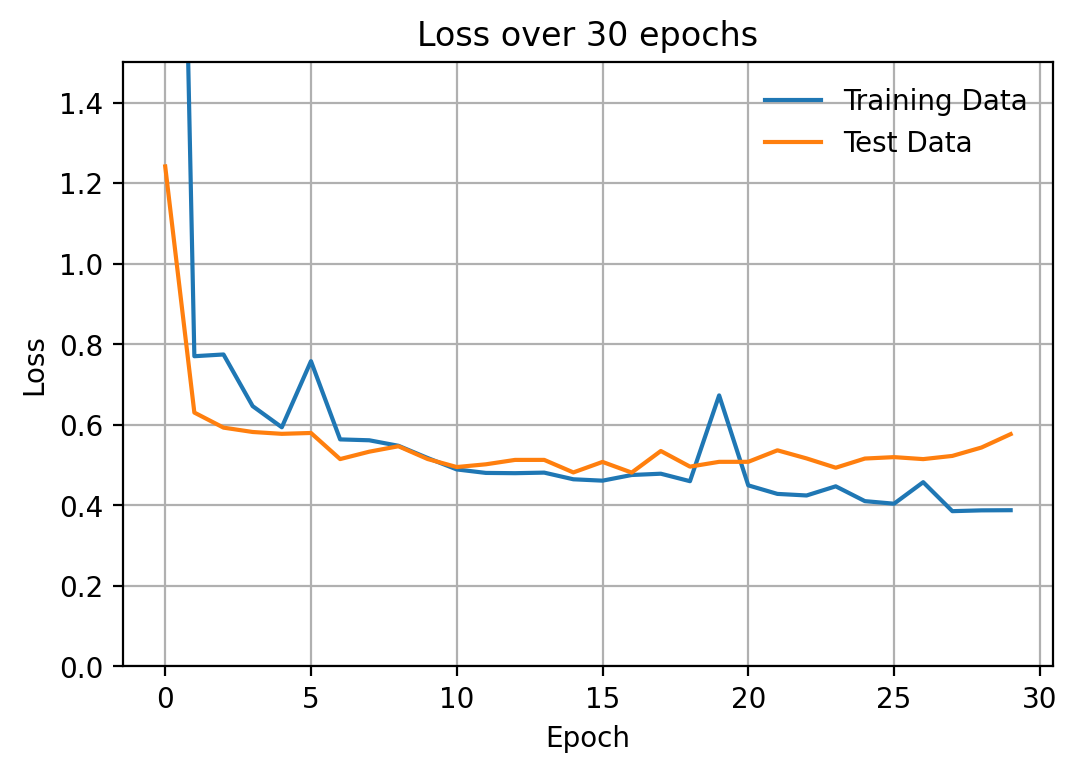

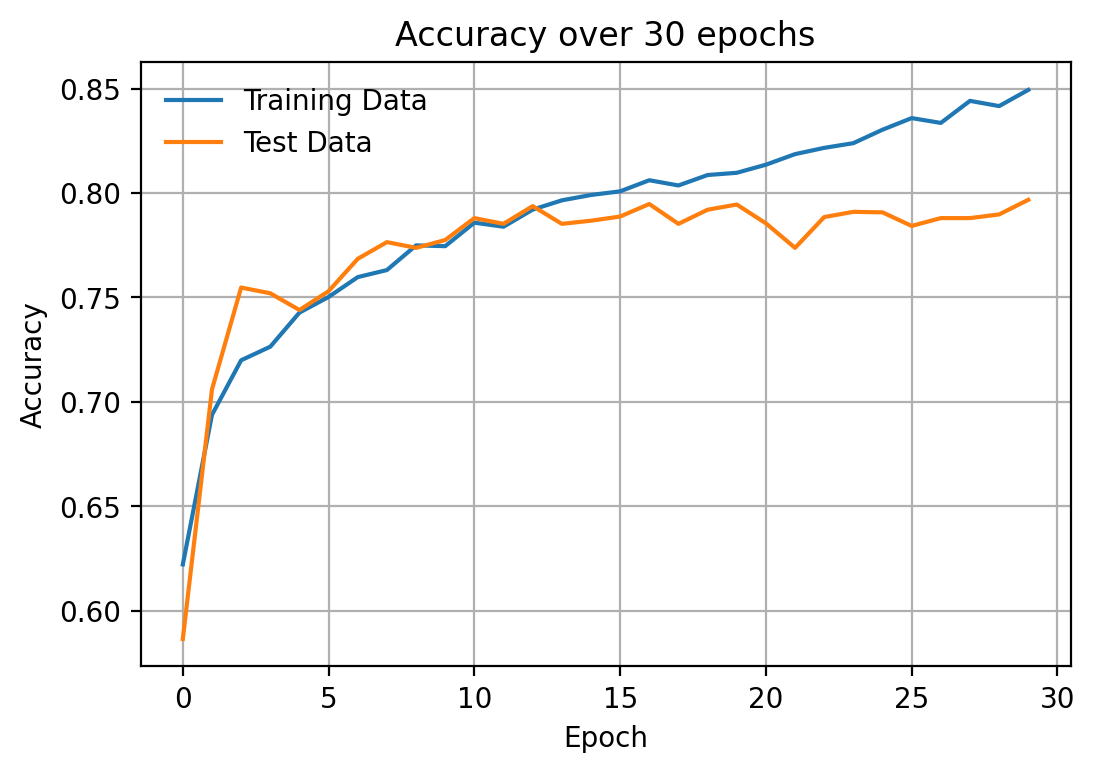

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label = "Training Data") #training loss
plt.plot(history.history['val_loss'], label = "Test Data") #test loss
plt.xlabel("Epoch")
plt.grid(True, which="both")
plt.title("Loss over 30 epochs")
plt.ylim(0,1.5)
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.figure()
plt.plot(history.history['accuracy'], label = "Training Data") #training loss
plt.plot(history.history['val_accuracy'], label = "Test Data") #test loss
plt.legend()
plt.grid(True, which="both")
plt.title("Accuracy over 30 epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

#### Brief comments:

The loss and accuracy of the training data is decreasing with every epoch and it would get better if continued. However, this is not the case with the test data due to overfitting. Different configurations and frequency of `dropout` was applied to the CNN yet the data kept overfitting or underfitting (if too much dropout). 

Furthermore, adding noise to the data made the performance worse due to the nature of the images. The jets are not large in the image and therefore a random distribution of noise throughout the 40x40 pixel will barely affect the "jet area" of the image. 

Therefore, it is most likely that the minute dataset is the issue. The total dataset is only 20,000 images. This is small for CNN trying to differentiate a small number of pixels (which represent the jets) compared to a large image dataset like MNIST (where there are 60,000 images and the images have more pixels). A much larger dataset is needed.

### ROC Curve

For binary classifications, the predictions of the CNN are of 4 categories. True Positive results (TP; the amount of times the CNN got the positive result (or a QCD-jet in this case) correct). False Positive results (FP; the amount of times the CNN got the positive result incorrect. True negatives results (TN; the amount of times the CNN got the negative result (or a W-jet in this case) correct. False negatives results (FN; the amount of times the CNN got the negative result (or a W-jet in this case) incorrect.

A popular way to evaluate the performance of a CNN is the Reciever Operating Characteristics (ROC) curve. It is a plot of the true positive rate (TPR) against the false positive rate (FPR). 

The true positive rate is the measure of how much the CNN classified the positive result correctly when cosidering all actual positives [11]: 

\
$$TPR = \frac{TP}{TP+FN}$$

\\

The false positive rate is a measure of how much the CNN classified the positive result incorrectly when considering all actual negatives [11]:

\
$$FPR = \frac{FP}{FP+TN}$$

\
The ROC curve plots TPR against FPR for different thresholds. The threshold is the probability at or beyond which the result will be classified as positive [11]. Normally the threshold is set at 0.5 but `roc_curve()` changes to different thresholds and plots TPR/FPR which forms the ROC curve. 

There are 1209 number of thresholds (i.e number of points) used to plot the ROC-curve.


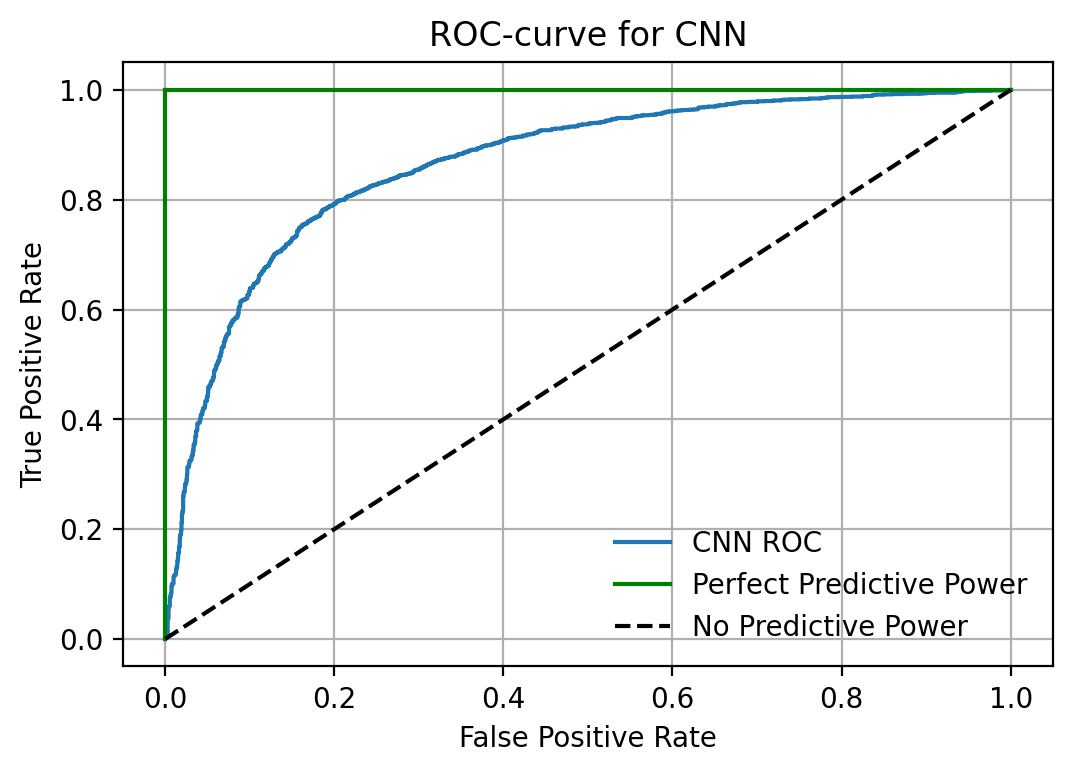

In [ ]:
prediction = CNN.predict(X_test) #the test prediction required to assess performance
fpr, tpr, threshold = roc_curve(y_test, prediction) #labels and prediction is required to calculate TPR and FPR
print("There are", len(threshold), "number of thresholds (i.e number of points) used to plot the ROC-curve.")


plt.figure()
plt.plot(fpr,tpr, label='CNN ROC')
plt.plot([0,0],[0,1], color='green', label='Perfect Predictive Power') #plot for perfect CNN comparison
plt.plot([0,1],[1,1], color='green')
plt.plot([0,1],[0,1], '--', color='black', label='No Predictive Power' ) #straight line for comparison
plt.legend()
plt.grid(True, which="both")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-curve for CNN")
plt.show()

A CNN performance is measured in terms of its predictive power. The bigger the area of the ROC curve the better the TPR and therefore the greater the predictive power [11]. The plots for the ROC curve, "perfect predictive power" ROC curve and "no predictive power" ROC curve is shown above.

The less FPRs the CNN has the better. This means that greater area the ROC curve has the better the performance of the CNN. We can visually see that the greatest area would be when the curve is a right-angle. However, we can also quantify this by calculated the area under the ROC curve.  `roc_auc_score` was used to obtain the AUC.

In [ ]:
roc_auc = roc_auc_score(y_test, prediction) #requires labels and predictions (which are probabilities)


print("The area under the ROC-curve is =", roc_auc) 

The area under the ROC-curve is = 0.8653504942335255


#### Brief comments:

The curve is closer to the perfect curve than the straight line. This shows good predictive power which is reinforced by an AUC of >0.85. However, it is not anything exceptional. This is mainly due to, again, the lack of training data. A much larger data set is needed. 

### Precision-Recall Curve


This is another measure of the performance of binary classification nueral networks. Precision is the rate at which the CNN gets the positive result correctly when considering all the positive predictions [12].

\\
$$Precision = \frac{TP}{TP+FP}$$

\\

And recall is the another name for the TPR. The AUC of the PR curve can be calculated to quantify the predictive power represented by the curve much like the ROC curve.

Another meaaure of performance is the F1-score (also called F-score). This has the equation [12]:

\\
$$F_1 = 2 \frac{precision × recall}{precision + recall}$$

\\

The F1-score is the harmonic mean of the precision and recall [9]. The highest possible value is 1 and the lowest is 0 where 1 is a perfect score. `precision_recall_curve`, `f1_score` and `auc` form `sklearn.metrics` was used to obtain the PR-curve, F1-score and AUC respectfully:

There are 3985 number of thresholds (i.e number of points) used to plot the PR-curve.




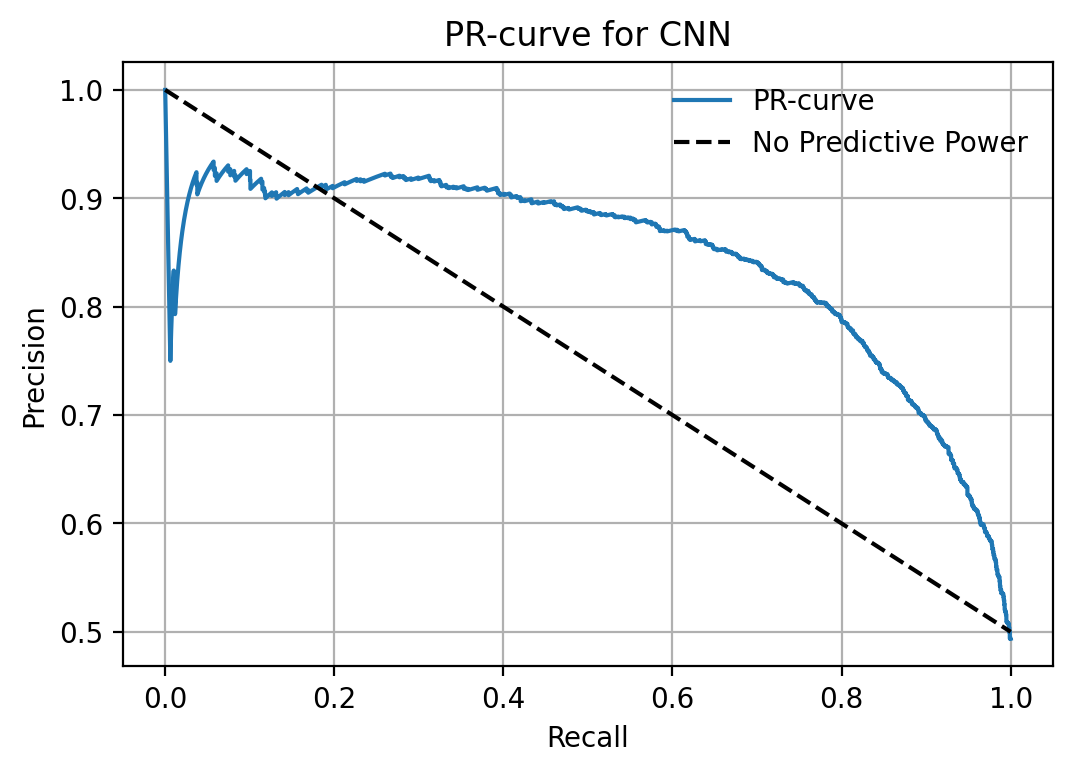



The area under the PR-curve is:  0.8447501316303626

The F1-score is: 0.7955045199120451


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, prediction)
print("There are", len(thresholds), "number of thresholds (i.e number of points) used to plot the PR-curve.")
print() #space
print()


plt.figure()
plt.plot(recall,precision, label="PR-curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0,1],[1,0.5], '--', color='black', label='No Predictive Power' )
plt.title("PR-curve for CNN")
plt.legend()
plt.grid(True, which="both")
plt.show()
print()
print()

pr_auc = auc(recall, precision) #auc
print("The area under the PR-curve is: ",pr_auc) 

print()

f1 = (2 * precision * recall) / (precision + recall)
print("The F1-score is:",f1[np.argmax(f1)])

#### Brief comments

The curve appears to have a high area. This shows good predictive power which is reinforced by an AUC of ~0.85. The F1-score is also high. However, it is not anything exceptional. This is mainly due to, again, the lack of training data. A much larger data set is needed. Also, there is a sharp drop at the begining of the curve. This is due to drops in correct classification (ie rise is false positives) since precision decreases (see equation above) 
[10].

### Rejection-Efficiency curve:

Background rejection is defined as:

$$Rejection = \frac{1}{FPR} = \frac{FP + TN}{FP}$$

\\
and efficiency is just the TPR. The rejection-efficiency curve is similar to the ROC curve. The area under the curve is the same. 

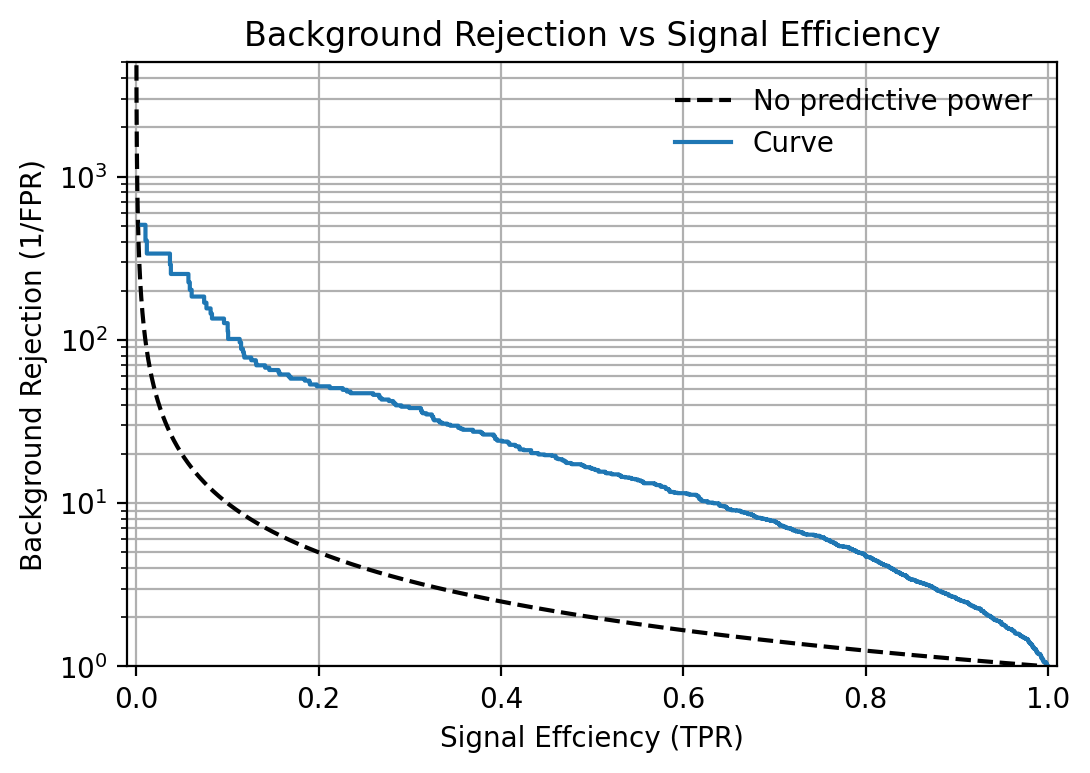

In [ ]:
np.seterr(divide='ignore', invalid='ignore') #ignore divide by 0

plt.figure()
plt.plot(thresholds, 1/thresholds, '--', color="black", label="No predictive power") #no predictive power from [2]
plt.plot(tpr,1/fpr, label="Curve")
plt.title('Background Rejection vs Signal Efficiency')
plt.xlabel("Signal Effciency (TPR)")
plt.ylabel("Background Rejection (1/FPR)")
plt.gca().set(xlim=(-0.01,1.01), ylim=(1,5*10**3), yscale='log') #log scale and limits
plt.grid(True, which="both")
plt.legend()
plt.show()

print()
print()

#re_auc = auc(tpr, 1/fpr) #auc
#print("The area under the Rejection-Efficiency curve is: ",re_auc) 

#### Brief comments:

Like the ROC curve, the curve is relativley far from the "no predictive power" line. This shows good predictive power which is reinforced by an AUC of >0.85. However, it is not anything exceptional. This is mainly due to, again, the lack of training data. A much larger data set is needed.

### NB: The discussion in this notebook are brief and will be elaborated on in the corresponding report.

### Bibliography:

[1] K. Team, “Keras documentation: Dense layer,” keras.io. https://keras.io/api/layers/core_layers/dense/ (accessed Jan. 10, 2022).


‌
[2] Ilmonteux, “Jet tagging in one hour with convolutional neural networks,” Excursions in data, Oct. 15, 2018. https://ilmonteux.github.io/2018/10/15/jet-tagging-cnn.html (accessed Jan. 12, 2022).



[3] S. Macaluso, "Pulling Out All the Tops with Computer Vision and Deep Learning", NHETC, Dept. of Physics and Astronomy
Rutgers, The State University of NJ Piscataway, NJ 08854 USA.



[4] K. Team, “Keras documentation: MaxPooling2D layer,” keras.io. https://keras.io/api/layers/pooling_layers/max_pooling2d/ (accessed Jan. 2, 2022).



‌
[5] K. Team, “Keras documentation: Dropout layer,” keras.io. https://keras.io/api/layers/regularization_layers/dropout/ (accessed Jan. 15, 2022).
‌


[6] K. Team, “Keras documentation: Flatten layer,” keras.io. https://keras.io/api/layers/reshaping_layers/flatten/ (accessed Jan. 167, 2022).
‌
‌

[7] M. Strassler, “Jets: The Manifestation of Quarks and Gluons,” Of Particular Significance, Oct. 20, 2011. https://profmattstrassler.com/articles-and-posts/particle-physics-basics/the-known-apparently-elementary-particles/jets-the-manifestation-of-quarks-and-gluons/ (accessed Jan. 9, 2022).



[8] “How to choose cross-entropy loss function in Keras?,” knowledge Transfer, May 22, 2021. https://androidkt.com/choose-cross-entropy-loss-function-in-keras/ (accessed Jan. 17, 2022).

[9] J. Korstanje, “The F1 score,” Medium, Aug. 31, 2021. https://towardsdatascience.com/the-f1-score-bec2bbc38aa6 (accessed Jan. 17, 2022).

[10] J. Brownlee, “How to Use ROC Curves and Precision-Recall Curves for Classification in Python,” Machine Learning Mastery, Aug. 30, 2018. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ (accessed Jan. 7, 2022).
‌

‌[11] S. Narkhede, “Understanding AUC - ROC Curve,” Medium, Jun. 26, 2018. https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5 (accessed Jan. 8, 2022).
‌

[12] Koo Ping Shung, “Accuracy, Precision, Recall or F1?,” Towards Data Science, Mar. 15, 2018. https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9 (accessed Jan. 17, 2022).
‌

‌